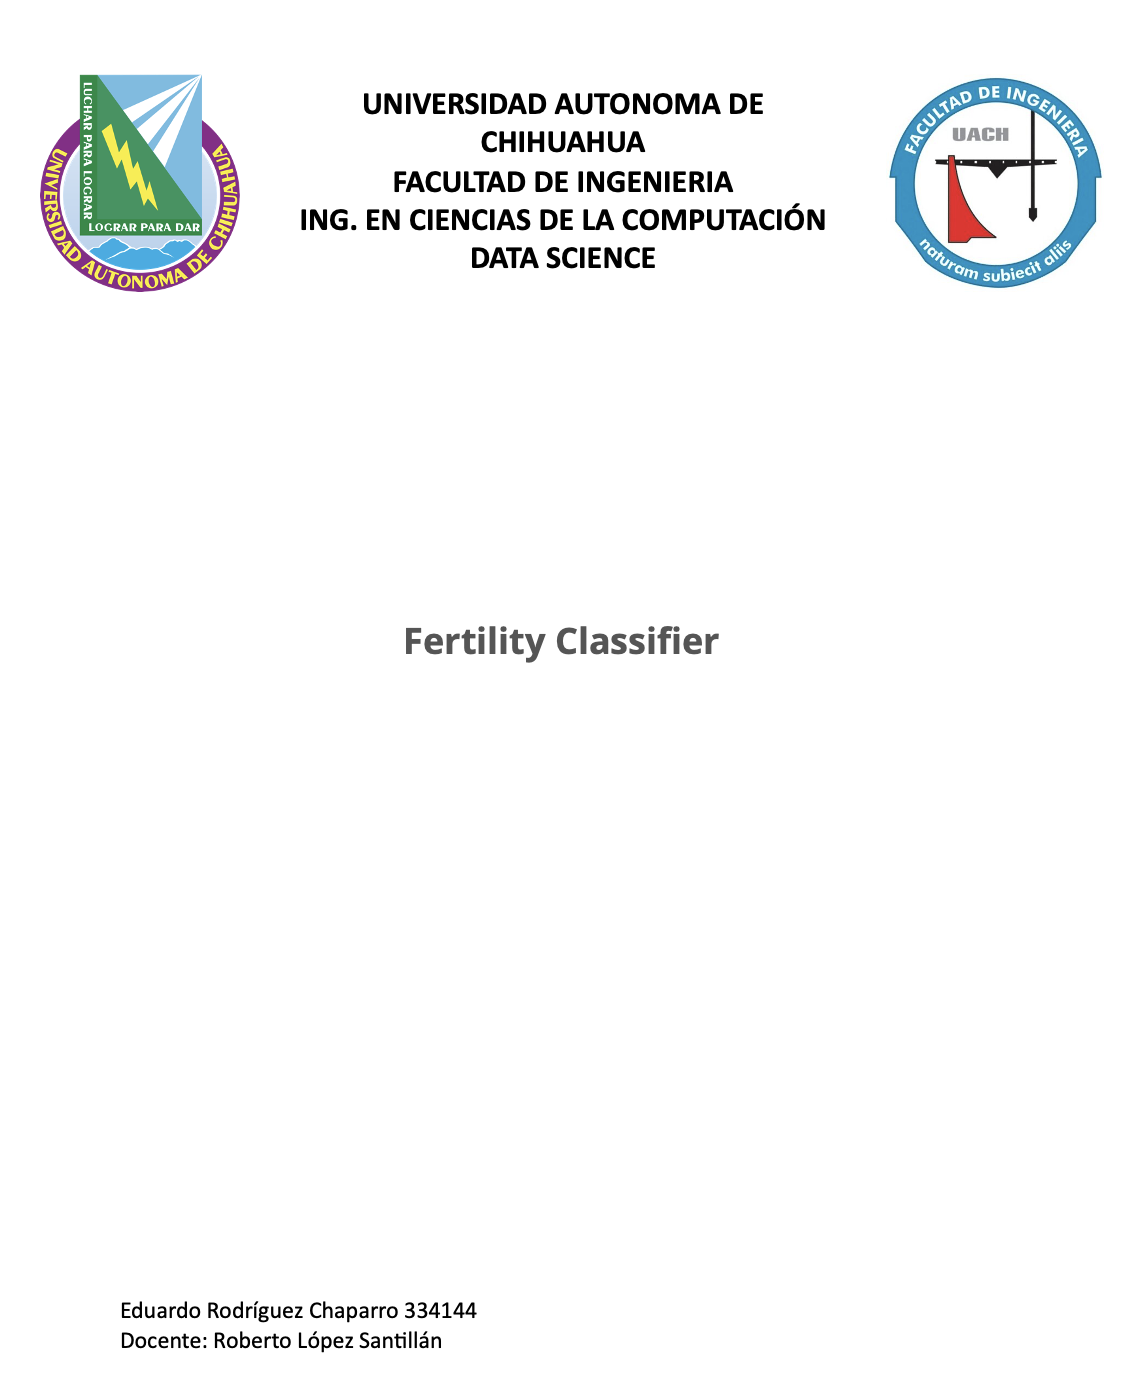

In [1]:
# Importamos el dataset.
import pandas as pd

archivo_txt = "data.txt"

fertility = pd.read_csv(archivo_txt, sep=',')

fertility.head()

,Season,Age,Childish Diseases,Accident,Surgical,High fevers,Alcohol,Smoking,Sitting Hours,Output
0,-0.33,0.69,0,1,1,0,0.8,0,0.88,1
1,-0.33,0.94,1,0,1,0,0.8,1,0.31,0
2,-0.33,0.50,1,0,0,0,1.0,-1,0.50,1
3,-0.33,0.75,0,1,1,0,1.0,-1,0.38,1
4,-0.33,0.67,1,1,0,0,0.8,-1,0.50,0


In [2]:
# Divide el train y test pero se asegura que la proporción 
# de datos se mantenga en train y test.
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(fertility, fertility["Output"]):
    strat_train_set = fertility.loc[train_index]
    strat_test_set = fertility.loc[test_index]

In [4]:
# Dividimos el dataset en X e y
X_train = strat_train_set.drop('Output', axis=1)
y_train = strat_train_set['Output'].copy()
X_test = strat_test_set.drop('Output', axis=1)
y_test = strat_test_set['Output'].copy()

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(80, 9)
(80,)
(20, 9)
(20,)


In [6]:
# Matriz de correlación con respecto al Target
corr_matrix = fertility.corr()

corr_matrix['Output'].sort_values(ascending=False)

Output               1.000000
Alcohol              0.144760
Accident             0.141346
High fevers          0.121421
Childish Diseases    0.040261
Sitting Hours       -0.022964
Smoking             -0.045891
Surgical            -0.054171
Age                 -0.115229
Season              -0.192417
Name: Output, dtype: float64

# Support Vector Machine

In [7]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

# SVM
svm_clf = SVC()

# PIPELINE
svm_clf_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("svm_clf", svm_clf)
])

# Grid de parámetros para el clasificador SVC
param_grid = [
    {'svm_clf__C': [0.1, 1, 10, 100, 1000], 'svm_clf__kernel': ['linear'], 'svm_clf__probability': [True]},
    {'svm_clf__C': [0.1, 1, 10, 100, 1000], 'svm_clf__gamma': [0.001, 0.0001], 'svm_clf__kernel': ['rbf'], 'svm_clf__probability': [True]},
    {'svm_clf__C': [0.1, 1, 10, 100, 1000], 'svm_clf__gamma': [0.001, 0.0001], 'svm_clf__kernel': ['poly'], 'svm_clf__degree': [2, 3], 'svm_clf__probability': [True]}
] 

randomized_search = RandomizedSearchCV(
    svm_clf_pipeline, 
    param_grid, cv=5, 
    scoring='accuracy', 
    n_jobs=-1, 
    verbose=True, 
    random_state=42)

# FIT AL MODELO
randomized_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('svm_clf', SVC())]),
                   n_jobs=-1,
                   param_distributions=[{'svm_clf__C': [0.1, 1, 10, 100, 1000],
                                         'svm_clf__kernel': ['linear'],
                                         'svm_clf__probability': [True]},
                                        {'svm_clf__C': [0.1, 1, 10, 100, 1000],
                                         'svm_clf__gamma': [0.001, 0.0001],
                                         'svm_clf__kernel': ['rbf'],
                                         'svm_clf__probability': [True]},
                                        {'svm_clf__C': [0.1, 1, 10, 100, 1000],
                                         'svm_clf__degree': [2, 3],
                                         'svm_clf__gamma': [0.001, 0.0001],
                                         'svm_clf__kernel': ['poly'],
                                         'svm_clf__probability': [True]}],
                   random_state=42, scoring='accuracy', verbose=True)

In [26]:
# BEST_ESTIMATOR
final_model = randomized_search.best_estimator_
# FIT AL MODELO
final_model.fit(X_train, y_train)

import joblib
joblib.dump(final_model, 'modelos/svm.pkl')

In [12]:
from sklearn.model_selection import cross_val_predict

# PPREDICT CON DATOS DE PRUEBA
y_test_pred = final_model.predict(X_test)

######## CONFUSION MATRIX
from sklearn.metrics import confusion_matrix
print("Confusion Matrix")
print(confusion_matrix(y_test, y_test_pred))

######## PRECISION Y RECALL
from sklearn.metrics import precision_score, recall_score
print("Precision")
print(precision_score(y_test, y_test_pred))
print("Recall")
print(recall_score(y_test, y_test_pred))

######## F1 SCORE
from sklearn.metrics import f1_score
print("F1 Score")
print(f1_score(y_test, y_test_pred))

######## ROC AUC SCORE
from sklearn.metrics import roc_auc_score
print("ROC")
print(roc_auc_score(y_test, y_test_pred))


Confusion Matrix
[[ 0  2]
 [ 0 18]]
Precision
0.9
Recall
1.0
F1 Score
0.9473684210526316
ROC
0.5


# Random Forest Classifier

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

#RANDOM FOREST CLASSIFIER
rf_clf = RandomForestClassifier()

#PIPELINE
rf_clf_pipeline = Pipeline([
    ("pca", PCA()),
    ("rf_clf", rf_clf)
])

# PARAM_GRID RFC
param_grid = [
    {'rf_clf__n_estimators': [10, 100, 200, 500], 'rf_clf__max_features': [2, 4, 6, 8]},
    {'rf_clf__bootstrap': [False], 'rf_clf__n_estimators': [10, 100, 200, 500], 'rf_clf__max_features': [2, 3, 4]}
]

randomized_search = RandomizedSearchCV(rf_clf_pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=True, random_state=42)

# FIT. AL MODELO
randomized_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('pca', PCA()),
                                             ('rf_clf',
                                              RandomForestClassifier())]),
                   n_jobs=-1,
                   param_distributions=[{'rf_clf__max_features': [2, 4, 6, 8],
                                         'rf_clf__n_estimators': [10, 100, 200,
                                                                  500]},
                                        {'rf_clf__bootstrap': [False],
                                         'rf_clf__max_features': [2, 3, 4],
                                         'rf_clf__n_estimators': [10, 100, 200,
                                                                  500]}],
                   random_state=42, scoring='accuracy', verbose=True)

In [24]:
#MEJOR ESTIMADOR
final_model = randomized_search.best_estimator_

#ENTRENAR EL MODELO
final_model.fit(X_train, y_train)

import joblib
joblib.dump(final_model, 'modelos/rfc.pkl')

['modelos/rfc.pkl']

In [19]:
from sklearn.model_selection import cross_val_predict

# PREDICT CON LOS VALORES DE TESTING
y_test_pred = final_model.predict(X_test)

######## CONFUSION MATRIX
from sklearn.metrics import confusion_matrix
print("Confusion Matrix")
print(confusion_matrix(y_test, y_test_pred))

######## PRECISION Y RECALL
from sklearn.metrics import precision_score, recall_score
print("Precision")
print(precision_score(y_test, y_test_pred))
print("Recall")
print(recall_score(y_test, y_test_pred))

######## F1 SCORE
from sklearn.metrics import f1_score
print("F1 Score")
print(f1_score(y_test, y_test_pred))

######## ROC AUC SCORE
from sklearn.metrics import roc_auc_score
print("ROC")
print(roc_auc_score(y_test, y_test_pred))

Confusion Matrix
[[ 0  2]
 [ 1 17]]
Precision
0.8947368421052632
Recall
0.9444444444444444
F1 Score
0.918918918918919
ROC
0.4722222222222222


# Extra Trees

In [14]:
########################### EXTRA TREES #########################################
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV

# Crear el modelo ExtraTrees
extra_trees = ExtraTreesClassifier(random_state=42)

# Definir el espacio de búsqueda de hiperparámetros
param_grid_ET = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
# Crear un objeto GridSearchCV
grid_search_ET = GridSearchCV(extra_trees, param_grid_ET, cv=5, scoring='accuracy')

# Ajustar el modelo a los datos de entrenamiento
grid_search_ET.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=ExtraTreesClassifier(random_state=42),
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy')

In [25]:
import joblib
joblib.dump(final_model, 'modelos/et.pkl')

['modelos/et.pkl']

In [15]:
# Obtener los mejores hiperparámetros
best_params_ET = grid_search_ET.best_params_

# Obtener el mejor modelo entrenado con los mejores hiperparámetros
best_extra_trees_model = grid_search_ET.best_estimator_

final_predictions_ET = best_extra_trees_model.predict(X_test)

######## CONFUSION MATRIX
print("Confusion Matrix")
print(confusion_matrix(y_test, final_predictions_ET))

######## PRECISION Y RECALL
from sklearn.metrics import precision_score, recall_score
print("Precision")
print(precision_score(y_test, final_predictions_ET))
print("Recall")
print(recall_score(y_test, final_predictions_ET))

######## F1 SCORE
from sklearn.metrics import f1_score
print("F1 Score")
print(f1_score(y_test, final_predictions_ET))

######## ROC AUC SCORE
from sklearn.metrics import roc_auc_score
print("ROC")
print(roc_auc_score(y_test, final_predictions_ET))

Confusion Matrix
[[ 0  2]
 [ 1 17]]
Precision
0.8947368421052632
Recall
0.9444444444444444
F1 Score
0.918918918918919
ROC
0.4722222222222222
